In [1]:
# plot packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=20)

import os
import json
import numpy as np
import matplotlib.pyplot as plt

# others
import numpy as np
import os, time
import torch
import matplotlib.ticker as ticker  # ← if not already imported


In [7]:
def plot_confidence_intervals(O_true, means, lowers, uppers, out_dir="./", filename="coverage", labels=None,
                              xlabel='Observable', coverage=None,
                              title="Coverage", color='skyblue'):
    """
    Plot a vertical line for the true value and horizontal confidence intervals for a list of estimates.

    Parameters:
        O_true (float): The true value (plotted as a vertical line).
        means (list or array): List of mean values for each estimate.
        lowers (list or array): List of lower bounds of the confidence intervals.
        uppers (list or array): List of upper bounds of the confidence intervals.
        labels (list of str, optional): Labels for each row (e.g., method names).
        title (str): Title of the plot.
        color (str): Color of the confidence intervals.
    """
    
    means = np.asarray(means)
    lowers = np.asarray(lowers)
    uppers = np.asarray(uppers)
    N = len(means)

    if not (len(lowers) == len(uppers) == N):
        raise ValueError("means, lowers, and uppers must have the same length.")

    y_positions = np.arange(N)[::-1]  # top to bottom

    fig = plt.figure(figsize=(12, max(1.5, 0.030 * N)))  # adjust height based on number of intervals
    fig.patch.set_facecolor('white')
    ax1= fig.add_axes([0.15, 0.1, 0.5, 0.8])
    # Plot horizontal error bars
    for i in range(N):
        plt.plot([lowers[i], uppers[i]], [y_positions[i]]*2, color=color, lw=2)
        plt.plot(means[i], y_positions[i], 'o', color='black')  # mean point

    # Vertical line for the true value
    plt.axvline(O_true, color='red', linestyle='-', lw=3, label=xlabel+'*'+f'= {O_true:.2f}')

    # Labels
    if labels is not None:
        plt.yticks(y_positions, labels)
    else:
        plt.yticks([])

    plt.xlabel(xlabel,fontsize=22, fontname='serif')
    plt.title(title,fontsize=22, fontname='serif')
    font = font_manager.FontProperties(family='serif', size=20)
    plt.legend(prop=font, bbox_to_anchor=(1.05, 1),
        loc='upper left', frameon=False, 
        borderaxespad=0.)
    # Create the info text
    info_text = f"Total intervals: {N}"
    if coverage is not None:
        info_text += f"\nCoverage: {coverage:.2%}"
    plt.text(
        1.05, 0.9, info_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        fontsize=20, bbox=None,  # No frame
        family='serif'
    )
    plt.ylim(0, N)
    # Set wider x-axis limits
    x_min = min(lowers)
    x_max = max(uppers)
    x_range = x_max - x_min
    plt.xlim(x_min - 0.2 * x_range, x_max + 0.2 * x_range)
    plt.xticks(fontsize=14, fontname='serif')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    fig.savefig(filename + ".pdf")

    plt.show()


/tmp/ipykernel_3012687/895485407.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


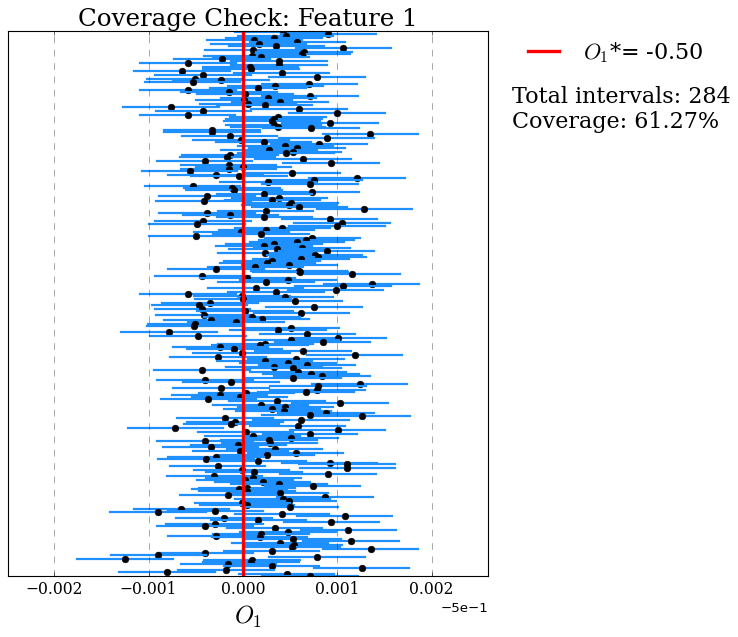

/tmp/ipykernel_3012687/895485407.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


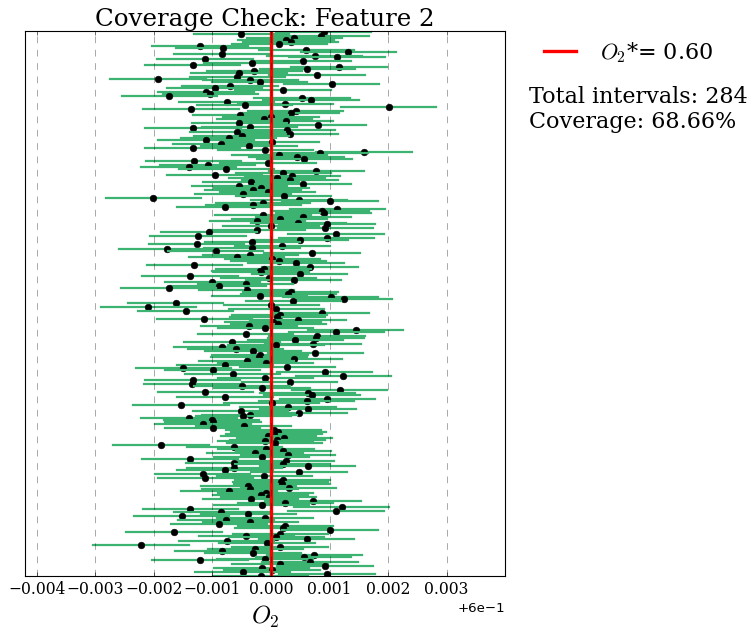

In [8]:
# Path to your folder
COVERAGE_DIR = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/wifi/Coverage_Check/coverage_outputs/N_100000_seeds_60_4_16_256_15_N_sampled_200000_l_1e5"

# Define output plot directory based on COVERAGE_DIR
COVERAGE_PLOTS_BASEDIR = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/Uncertainty_Modeling/wifi/Coverage_Check/coverage_plots"
folder_name = os.path.basename(COVERAGE_DIR)
plot_out_dir = os.path.join(COVERAGE_PLOTS_BASEDIR, folder_name)
os.makedirs(plot_out_dir, exist_ok=True)

# Initialize lists per feature (assume 2D)
means_0, lowers_0, uppers_0, within_0 = [], [], [], []
means_1, lowers_1, uppers_1, within_1 = [], [], [], []

# Load all toy files
for fname in os.listdir(COVERAGE_DIR):
    if fname.startswith("toy_") and fname.endswith(".json"):
        with open(os.path.join(COVERAGE_DIR, fname)) as f:
            data = json.load(f)

        mu = data["mu_model"][0]
        sigma = data["sigma_integral"]
        within = data["within_band"][0]

        # Feature 0
        means_0.append(mu[0])
        lowers_0.append(mu[0] - sigma[0])
        uppers_0.append(mu[0] + sigma[0])
        within_0.append(within[0])

        # Feature 1
        means_1.append(mu[1])
        lowers_1.append(mu[1] - sigma[1])
        uppers_1.append(mu[1] + sigma[1])
        within_1.append(within[1])

# Get the true values
with open(os.path.join(COVERAGE_DIR, os.listdir(COVERAGE_DIR)[0])) as f:
    O_true_0, O_true_1 = json.load(f)["mu_target"]

# Plot for Feature 0
plot_confidence_intervals(
    O_true=O_true_0,
    means=means_0,
    lowers=lowers_0,
    uppers=uppers_0,
    coverage=np.mean(within_0),
    xlabel=r'$O_1$',
    title="Coverage Check: Feature 1",
    color='dodgerblue',
    filename=os.path.join(plot_out_dir, "coverage1")
)

# Plot for Feature 1
plot_confidence_intervals(
    O_true=O_true_1,
    means=means_1,
    lowers=lowers_1,
    uppers=uppers_1,
    coverage=np.mean(within_1),
    xlabel=r'$O_2$',
    title="Coverage Check: Feature 2",
    color='mediumseagreen',
    filename=os.path.join(plot_out_dir, "coverage2")
)